## Introduction to Kaggle

In [24]:
import pandas as pd

train = pd.read_csv("train.csv")
train_shape = train.shape

test = pd.read_csv("test.csv")
test_shape = test.shape

## Exploring the Data

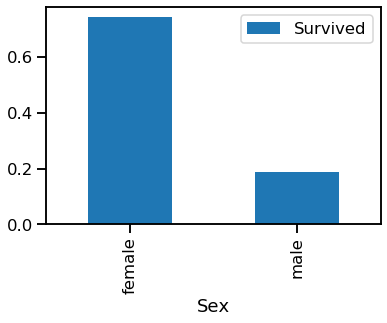

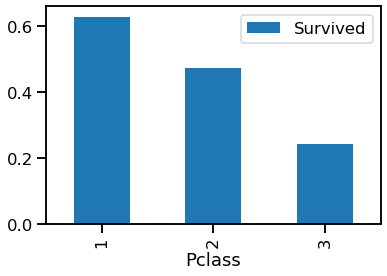

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

pclass_pivot = train.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

In [26]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## Exploring and Converting the Age Column

Create the cut_points and label_names lists to split the Age column into six categories:
* Missing, from -1 to 0
* Infant, from 0 to 5
* Child, from 5 to 12
* Teenager, from 12 to 18
* Young Adult, from 18 to 35
* Adult, from 35 to 60
* Senior, from 60 to 100

In [27]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [28]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train, cut_points, label_names)
test = process_age(test, cut_points, label_names)

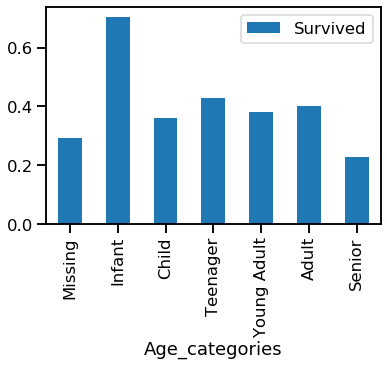

In [29]:
age_pivot = train.pivot_table(index="Age_categories",values="Survived")
age_pivot.plot.bar()
plt.show()

## Preparing our Data for Machine Learning

In [30]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train, "Sex")
test = create_dummies(test, "Sex")

train = create_dummies(train, "Age_categories")
test = create_dummies(test, "Age_categories")

## Creating Our First Machine Learning Model

In [31]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

from sklearn.linear_model import LogisticRegression

X = train[columns]
y = train['Survived']

lr = LogisticRegression()

lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
lr.score(X, y)

0.8080808080808081

## Splitting Our Training Data

In [33]:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

X = train[columns]
y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)


## Making Predictions and Measuring their Accuracy

In [34]:
from sklearn.metrics import accuracy_score

lr = LogisticRegression()

lr.fit(train_X, train_y)

predictions = lr.predict(test_X)

accuracy = accuracy_score(test_y, predictions)

print(accuracy)

0.8100558659217877


## Using Cross Validation for More Accurate Error Measurement

In [36]:
from sklearn.model_selection import cross_val_score
import numpy as np

lr = LogisticRegression()

scores = cross_val_score(lr, X, y, cv=10)

accuracy = np.mean(scores)

0.8024719101123596

In [38]:
print(scores)
print(accuracy)

[0.8        0.82022472 0.76404494 0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80898876]
0.8100558659217877


## Making Predictions on Unseen Data

In [40]:
lr = LogisticRegression()

lr.fit(X, y)

holdout_predictions = lr.predict(test[columns])

## Creating a Submission File

In [42]:
holdout = test
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv('submission.csv', index=False)